In [1]:
# read ans process files 
import pandas as pd
import numpy as np
import json
import csv
import re

# neo4j DB
from neo4j.v1 import GraphDatabase
uri = "bolt://localhost:7687"

# libs for lemmatized and stemmaed strings
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem import PorterStemmer


import nltk
nltk.download('wordnet')

# sklearn for LDA and grid search
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# plotting
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to /home/jeslev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Object for Neo4J Database

In [2]:
class Application(object):
    
    def __init__(self, uri):
        self._driver = GraphDatabase.driver(uri, auth=("neo4j", "password"))
        
    
    def close(self):
        self._driver.close()
    
    @staticmethod
    def query_get_text(tx, tweet_id):
        #print(tweet_id)
        result = tx.run("MATCH (n:Tweet ) WHERE n.id=$tid  "
                        " RETURN n.text", tid=tweet_id)
        #print("res ")
        #print(result.peek())
        if result.peek() is None:
            return None
        #print(result.single()[0])
        return result.single()[0]

    def getText(self,tweet_id):
        with self._driver.session() as session:
            tweet = session.read_transaction(self.query_get_text, tweet_id)
            return tweet

# Get data (not needed, we can read from file already processed)

In [64]:
#read file
filename = 'iot-tweets-2009-2016-complet-enrichie.tsv'
data = pd.read_csv(filename,sep='\t', na_values=['null','None','',], dtype=object)
data.set_index('TweetID');

,Sentiment,TopicID,Country,Gender,URLs,Text,User_ID,User_Name,Date,Hashtags,in_reply_to_status_id,Indication,Retweeted,Geo,Location,in_reply_to_user_id
TweetID,,,,,,,,,,,,,,,,
1093771552,neutral,0,us,andy,https://twitter.com/whatsshakin,"'First sign of twitter as transport for ""inter...",17635797,'djinoz','Tue Nov 25 23:37:02 +0000 2008',[],NaN,tweet,false,NaN,'127.0.0.1',NaN
1099404026,neutral,NaN,ca,male,https://en.wikipedia.org/wiki/Internet_of_Things,"""The Internet of Things. L'internet des objets...",14350762,'zecool','Thu Apr 10 12:57:29 +0000 2008',[],NaN,tweet,false,NaN,'Montréal,NaN
1099881858,neutral,2,gb,andy,NaN,'programming mirroir and nabaztag... Internet ...,12318782,'alezante','Wed Jan 16 14:22:22 +0000 2008',[],NaN,tweet,false,NaN,'London,NaN
1104012014,neutral,1,be,male,NaN,'aha mycrocosm integration & internet of thing...,16113118,'DriesDeRoeck','Wed Sep 03 13:59:13 +0000 2008',[],NaN,tweet,false,NaN,'Antwerp,NaN
1104556075,neutral,0,it,andy,NaN,'The concept is basically The Internet of Things',18074191,'ZeugmaMedia','Fri Dec 12 10:54:04 +0000 2008',[],NaN,tweet,false,NaN,'Florence,NaN
1104557021,neutral,2,it,andy,NaN,'As I see the evolution: Internet of Websites ...,18074191,'ZeugmaMedia','Fri Dec 12 10:54:04 +0000 2008',[],NaN,tweet,false,NaN,'Florence,NaN
1104680554,neutral,2,us,male,https://techcrunch.com/2009/01/08/microsoft-re...,'Cellphones are barcode readers. Here comes th...,14363195,'rbectel','Fri Apr 11 18:14:15 +0000 2008',[],NaN,tweet,false,NaN,'Alexandria,NaN
1105498266,neutral,1,us,male,http://dogearnation.com,'@michaelrove01 can you point me to the interv...,743913,'davidorban','Thu Feb 01 16:52:22 +0000 2007',[],NaN,tweet,false,NaN,'New York,NaN
1108665373,neutral,NaN,fr,male,https://www.mbed.com/en/EN/6lowpan/faq.htm/,'The internet of things http://www.sensinode.c...,749143,'EricSalviac','Fri Feb 02 21:28:45 +0000 2007',[],NaN,tweet,false,NaN,'',NaN


In [ ]:
# construction de conversation matrix id_tweet text id_conversation 
corpus = list()#pd.DataFrame(columns=['id_tweet', 'text', 'id_conversation'])

filename = 'conversations_tweet.txt'
file = open(filename, "r")
app = Application(uri)

id_conversation = 0

for conversation in file:
    
    ids = conversation.strip().split()
    
    if len(ids)<2:
        continue
    
    if id_conversation % 10000 == 0:
        print(id_conversation)
    
#     tmp = data.loc[data['TweetID'].isin(ids)][['TweetID','Text']]
#     for index,row in tmp.iterrows():
#         corpus.append([row[0], row[1],  id_conversation] )
    for idt in ids:
        text = app.getText(idt)
        if text is None or len(text)==0:
            continue
        corpus.append([idt, text, id_conversation])
    id_conversation += 1

In [66]:
df = pd.DataFrame.from_records(corpus,columns=['TweetID', 'Text', 'IDConv'])

In [67]:
df.to_csv('PandasConvLen>1.csv', encoding='utf-8', index=False)

## Read file already processed

In [5]:
df = pd.read_csv('PandasConvLen>1.csv',sep=',', na_values=['null','None','',], dtype=object)
df.fillna('')
df.head(5)

,TweetID,Text,IDConv
0,492759449325797376,'#Boston &amp; the growing Internet of Things ...,0
1,492760403202433024,'.@BetsyMunnell We unlocked the Internet of Th...,0
2,706626381707354112,'The #IoT is just starting to catch up with #M...,1
3,706871108348342272,'Only two of you jumped the link to the Trends...,1
4,560866242118963203,"'@johnsheehan ""I\'m building an #IoT system us...",2


# Data pre-processing
- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
- Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
- Words are stemmed — words are reduced to their root form.

In [6]:
def lemmatize_stemming(text):
    porter = PorterStemmer()
    return porter.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    text = text.replace('\\n','')
    text = re.sub('http://\S+|https://\S+','', text)
    text = re.sub("\'",'', text) # single quotes
    #text = re.sub('\s+','', text) # new line
    text = re.sub('\S*@\S*\s?','', text) # email
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

def preprocess2(text):
    text = text.replace('\\n','')
    text = re.sub('http://\S+|https://\S+','', text)
    text = re.sub("\'",'', text) # single quotes
    #text = re.sub('\s+','', text) # new line
    text = re.sub('\S*@\S*\s?','', text) # email
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return (" ".join(result)).strip()

<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \S
<>:20: DeprecationWarning: invalid escape sequence \S
<>:23: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \S
<>:20: DeprecationWarning: invalid escape sequence \S
<>:23: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \S
<>:20: DeprecationWarning: invalid escape sequence \S
<>:23: DeprecationWarning: invalid escape sequence \S
<ipython-input-6-f29d5e35b445>:7: DeprecationWarning: invalid escape sequence \S
  text = re.sub('http://\S+|https://\S+','', text)
<ipython-input-6-f29d5e35b445>:10: DeprecationWarning: invalid escape sequence \S
  text = re.sub('\S*@\S*\s?','', text) # email
<ipython-input-6-f29d5e35b445>:20: DeprecationWarning: invalid escape sequence \S
  text = re.

In [7]:
#test
doc_sample = df[df['TweetID']=='706871108348342272'].values[0][1]
doc_sample = doc_sample.replace('\\n',' ')
doc_sample = re.sub("\'",'', doc_sample) # single quotes
#doc_sample = re.sub('\s+','', doc_sample) # new line
doc_sample = re.sub('\S*@\S*\s?','', doc_sample) # email
doc_sample = re.sub('http://\S+|https://\S+','', doc_sample) # remove http url
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

<>:6: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \S
<ipython-input-7-78b5539e6ec3>:6: DeprecationWarning: invalid escape sequence \S
  doc_sample = re.sub('\S*@\S*\s?','', doc_sample) # email
<ipython-input-7-78b5539e6ec3>:7: DeprecationWarning: invalid escape sequence \S
  doc_sample = re.sub('http://\S+|https://\S+','', doc_sample) # remove http url


original document: 
['Only', 'two', 'of', 'you', 'jumped', 'the', 'link', 'to', 'the', 'Trends', 'graphs?', '', '#IoT', '#MrRobot']


 tokenized and lemmatized document: 
['jump', 'link', 'trend', 'graph', 'mrrobot']


In [9]:
%xmode Plain
processed_docs = df['Text'].map(preprocess)
#processed_docs2 = df['Text'].map(preprocess2)
processed_docs[4310]

Exception reporting mode: Plain


['infograph', 'internet', 'thing', 'catch', 'tech']

# Bag of Words on the Data set
Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [10]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    if v is None:
        continue
    print(k, v)
    count += 1
    if count > 10:
        break


0 boston
1 grow
2 industri
3 internet
4 paywal
5 read
6 thing
7 cover
8 free
9 stori
10 today


Filter out tokens that appear in

- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 100000 most frequent tokens.
 

In [11]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.

In [12]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(3, 1), (5, 1), (11, 1), (53, 1), (1397, 1)]

In [13]:
# Preview Bag Of Words for our sample preprocessed document.
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 3 ("internet") appears 1 time.
Word 5 ("thing") appears 1 time.
Word 11 ("catch") appears 1 time.
Word 53 ("tech") appears 1 time.
Word 1397 ("infograph") appears 1 time.


In [22]:
df.iloc[4310]['Text']

'"[Infographic]: Why the #Internet of Things Hasn\'t Really Caught On Yet: | #IoT #Tech http://t.co/K1nFFOaRQZ"'

# TF-IDF
Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [14]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.646162616419618),
 (1, 0.5037426627700409),
 (2, 0.3583146138285427),
 (3, 0.11691376339598454),
 (4, 0.4161617576563497),
 (5, 0.11605345215447105)]


# Running LDA using Bag of Words
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [16]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2, random_state=42)

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

In [17]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.049*"connect" + 0.040*"devic" + 0.023*"servic" + 0.020*"secur" + 0.019*"agre" + 0.018*"manag" + 0.018*"smart" + 0.017*"challeng" + 0.016*"custom" + 0.015*"citi"
Topic: 1 
Words: 0.350*"thing" + 0.344*"internet" + 0.007*"futur" + 0.007*"connect" + 0.007*"industri" + 0.006*"mean" + 0.006*"infograph" + 0.005*"need" + 0.005*"think" + 0.005*"come"
Topic: 2 
Words: 0.069*"wearabl" + 0.037*"market" + 0.031*"tech" + 0.023*"year" + 0.022*"technolog" + 0.016*"devic" + 0.014*"futur" + 0.014*"world" + 0.012*"wearabletech" + 0.012*"healthcar"
Topic: 3 
Words: 0.038*"chang" + 0.033*"busi" + 0.025*"googl" + 0.020*"home" + 0.017*"control" + 0.016*"model" + 0.015*"consum" + 0.015*"smart" + 0.014*"robot" + 0.010*"light"
Topic: 4 
Words: 0.064*"thank" + 0.053*"great" + 0.023*"share" + 0.021*"articl" + 0.020*"iotchat" + 0.019*"today" + 0.017*"check" + 0.016*"love" + 0.014*"read" + 0.013*"blog"
Topic: 5 
Words: 0.076*"secur" + 0.027*"mobil" + 0.021*"hack" + 0.016*"privaci" + 0.014*"cyber

In [18]:
#test
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))



Score: 0.5096114277839661	 
Topic: 0.350*"thing" + 0.344*"internet" + 0.007*"futur" + 0.007*"connect" + 0.007*"industri" + 0.006*"mean" + 0.006*"infograph" + 0.005*"need" + 0.005*"think" + 0.005*"come"

Score: 0.18978619575500488	 
Topic: 0.069*"wearabl" + 0.037*"market" + 0.031*"tech" + 0.023*"year" + 0.022*"technolog" + 0.016*"devic" + 0.014*"futur" + 0.014*"world" + 0.012*"wearabletech" + 0.012*"healthcar"

Score: 0.18392671644687653	 
Topic: 0.039*"look" + 0.023*"talk" + 0.017*"develop" + 0.016*"know" + 0.016*"interest" + 0.015*"peopl" + 0.015*"forward" + 0.015*"right" + 0.014*"work" + 0.014*"cool"

Score: 0.016669975593686104	 
Topic: 0.084*"data" + 0.042*"like" + 0.040*"bigdata" + 0.028*"analyt" + 0.021*"industri" + 0.017*"need" + 0.014*"iiot" + 0.012*"tech" + 0.011*"machin" + 0.011*"strategi"

Score: 0.016669495031237602	 
Topic: 0.064*"thank" + 0.053*"great" + 0.023*"share" + 0.021*"articl" + 0.020*"iotchat" + 0.019*"today" + 0.017*"check" + 0.016*"love" + 0.014*"read" + 0.013

# Running LDA using TF-IDF

In [23]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4, random_state=42)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

Topic: 0 Word: 0.015*"connect" + 0.015*"internet" + 0.015*"thing" + 0.014*"agre" + 0.011*"devic" + 0.009*"read" + 0.009*"manag" + 0.009*"smart" + 0.009*"android" + 0.009*"process"
Topic: 1 Word: 0.104*"thing" + 0.103*"internet" + 0.014*"industri" + 0.013*"futur" + 0.011*"mean" + 0.011*"welcom" + 0.010*"interest" + 0.008*"connect" + 0.008*"think" + 0.008*"come"
Topic: 2 Word: 0.021*"market" + 0.021*"thing" + 0.020*"internet" + 0.016*"infograph" + 0.013*"wearabl" + 0.010*"trillion" + 0.010*"year" + 0.008*"devic" + 0.008*"true" + 0.008*"hype"
Topic: 3 Word: 0.020*"thing" + 0.020*"internet" + 0.019*"chang" + 0.016*"busi" + 0.012*"model" + 0.009*"healthcar" + 0.007*"care" + 0.007*"googl" + 0.006*"light" + 0.006*"connect"
Topic: 4 Word: 0.047*"thank" + 0.026*"share" + 0.018*"articl" + 0.017*"great" + 0.013*"thing" + 0.013*"internet" + 0.009*"iotchat" + 0.008*"today" + 0.008*"check" + 0.007*"appl"
Topic: 5 Word: 0.026*"cloud" + 0.025*"bigdata" + 0.015*"devop" + 0.012*"thing" + 0.012*"internet

/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/jeslev/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

In [25]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.3935403525829315	 
Topic: 0.021*"market" + 0.021*"thing" + 0.020*"internet" + 0.016*"infograph" + 0.013*"wearabl" + 0.010*"trillion" + 0.010*"year" + 0.008*"devic" + 0.008*"true" + 0.008*"hype"

Score: 0.31923285126686096	 
Topic: 0.104*"thing" + 0.103*"internet" + 0.014*"industri" + 0.013*"futur" + 0.011*"mean" + 0.011*"welcom" + 0.010*"interest" + 0.008*"connect" + 0.008*"think" + 0.008*"come"

Score: 0.17054252326488495	 
Topic: 0.019*"look" + 0.014*"thing" + 0.014*"internet" + 0.013*"forward" + 0.009*"right" + 0.009*"join" + 0.007*"nice" + 0.007*"great" + 0.007*"your" + 0.007*"talk"

Score: 0.01667173206806183	 
Topic: 0.019*"thing" + 0.019*"internet" + 0.015*"know" + 0.011*"like" + 0.011*"trend" + 0.011*"need" + 0.010*"tech" + 0.009*"data" + 0.008*"home" + 0.008*"compani"

Score: 0.016669342294335365	 
Topic: 0.047*"thank" + 0.026*"share" + 0.018*"articl" + 0.017*"great" + 0.013*"thing" + 0.013*"internet" + 0.009*"iotchat" + 0.008*"today" + 0.008*"check" + 0.007*"appl"



In [26]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.39016860723495483	 
Topic: 0.021*"market" + 0.021*"thing" + 0.020*"internet" + 0.016*"infograph" + 0.013*"wearabl" + 0.010*"trillion" + 0.010*"year" + 0.008*"devic" + 0.008*"true" + 0.008*"hype"

Score: 0.32096052169799805	 
Topic: 0.104*"thing" + 0.103*"internet" + 0.014*"industri" + 0.013*"futur" + 0.011*"mean" + 0.011*"welcom" + 0.010*"interest" + 0.008*"connect" + 0.008*"think" + 0.008*"come"

Score: 0.17218658328056335	 
Topic: 0.019*"look" + 0.014*"thing" + 0.014*"internet" + 0.013*"forward" + 0.009*"right" + 0.009*"join" + 0.007*"nice" + 0.007*"great" + 0.007*"your" + 0.007*"talk"

Score: 0.016671733930706978	 
Topic: 0.019*"thing" + 0.019*"internet" + 0.015*"know" + 0.011*"like" + 0.011*"trend" + 0.011*"need" + 0.010*"tech" + 0.009*"data" + 0.008*"home" + 0.008*"compani"

Score: 0.016669338569045067	 
Topic: 0.047*"thank" + 0.026*"share" + 0.018*"articl" + 0.017*"great" + 0.013*"thing" + 0.013*"internet" + 0.009*"iotchat" + 0.008*"today" + 0.008*"check" + 0.007*"appl"

In [ ]:
#import dill
#dill.dump_session('notebook_env.db')

In [ ]:
#import dill
#dill.load_session('notebook_env.db')

source: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

## Save models LDA

In [27]:
>>> from gensim.test.utils import datapath
>>>
>>> # Save model to disk.
>>> temp_file = datapath("modelNormal")
>>> lda_model.save(temp_file)
>>> temp_file2 = datapath("modelTFIDF")
>>> lda_model_tfidf.save(temp_file2)

>>>
>>> # Load a potentially pretrained model from disk.
>>> #lda = LdaModel.load(temp_file)

# Assign topics to rows

In [55]:
tweets_results_lda = list()
sz = len(bow_corpus)
for row in range(sz):
    #if row>10:
    #    break
    tweet = df.iloc[row]
    words = bow_corpus[row]
    tt = np.zeros(10)
    for index,score in lda_model[words]:
        tt[index] = score
    row = [tweet[0], tweet[2] ]
    row.extend(tt)
    tweets_results_lda.append(row)
len(tweets_results_lda)

163706

In [58]:
# Save file with all the topics score for each tweet
fields = ['TweetID', 'IDConv']
for t in range(10):
    fields.append('Topic'+str(t))
df_topics_scores = pd.DataFrame.from_records(tweets_results_lda,columns=fields)
df_topics_scores.to_csv('tweets_lda_all_topics.csv', encoding='utf-8', index=False)


In [59]:
tweets_results_lda = list()
sz = len(bow_corpus)
for row in range(sz):
    #if row>10:
    #    break
    tweet = df.iloc[row]
    words = bow_corpus[row]
    tt = np.zeros(10)
    for index,score in lda_model[words]:
        tt[index] = score
    topic_id = np.argmax(tt)
    row = [tweet[0], tweet[2], topic_id ]
    tweets_results_lda.append(row)
len(tweets_results_lda)

163706

In [60]:
# Save file with the highest score topic score for each tweet
fields = ['TweetID', 'IDConv', 'Topic']
df_topics_best_score = pd.DataFrame.from_records(tweets_results_lda,columns=fields)
df_topics_best_score.to_csv('tweets_lda_best_topic.csv', encoding='utf-8', index=False)
df_topics_best_score.head(5)

,TweetID,IDConv,Topic
0,492759449325797376,0,1
1,492760403202433024,0,4
2,706626381707354112,1,4
3,706871108348342272,1,4
4,560866242118963203,2,8


# LDA SCIKIT LEARN (seeking the best n_topics)

In [94]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=2,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(processed_docs2)

## Check the Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [95]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.09200628723667306 %


In [86]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=42,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

In [96]:
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

/home/jeslev/.local/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=10, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


## Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

Source: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [97]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -5708838.866176985
Perplexity:  1211.184151667693
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 10,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [102]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/home/jeslev/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [103]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -1892383.0040524371
Model Perplexity:  980.3614603581175


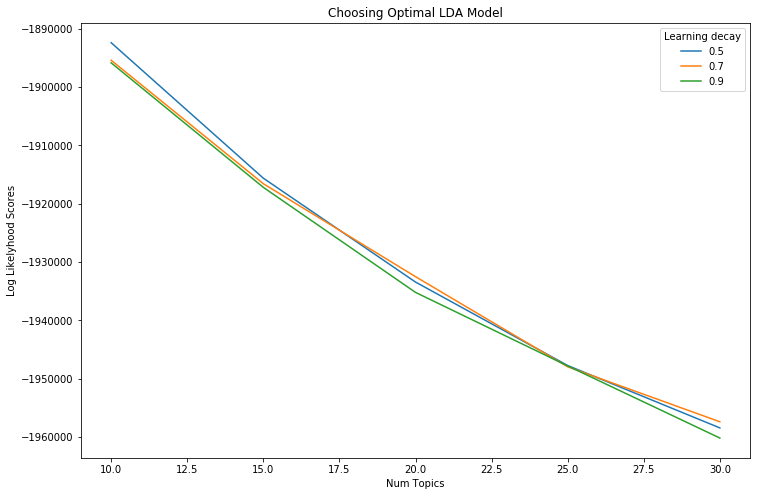

In [135]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline



# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(r) for r in results['mean_test_score'][0:5] ]
log_likelyhoods_7 = [round(r) for r in results['mean_test_score'][5:10] ]
log_likelyhoods_9 = [round(r) for r in results['mean_test_score'][10:15] ]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [120]:
results = model.cv_results_

In [127]:
results['params'][0:3],results['mean_test_score']

([{'learning_decay': 0.5, 'n_components': 10},
  {'learning_decay': 0.5, 'n_components': 15},
  {'learning_decay': 0.5, 'n_components': 20},
  {'learning_decay': 0.5, 'n_components': 25},
  {'learning_decay': 0.5, 'n_components': 30},
  {'learning_decay': 0.7, 'n_components': 10},
  {'learning_decay': 0.7, 'n_components': 15},
  {'learning_decay': 0.7, 'n_components': 20},
  {'learning_decay': 0.7, 'n_components': 25},
  {'learning_decay': 0.7, 'n_components': 30},
  {'learning_decay': 0.9, 'n_components': 10},
  {'learning_decay': 0.9, 'n_components': 15},
  {'learning_decay': 0.9, 'n_components': 20},
  {'learning_decay': 0.9, 'n_components': 25},
  {'learning_decay': 0.9, 'n_components': 30}],
 array([-1892383.00405244, -1915620.69375568, -1933437.69240265,
        -1947756.27742904, -1958458.70083461, -1895395.28249736,
        -1916569.979025  , -1932516.26908506, -1947978.72099258,
        -1957405.14503327, -1895839.2693865 , -1917194.49784149,
        -1935213.36671971, -194782